In [37]:
import pandas as pd
import numpy as np

df = pd.read_csv('C:/Product_Sale_Forecasting/data/final_featured_dataset.csv')
df.shape

(188340, 26)

In [38]:
df.head()

,ID,Store_id,Date,Holiday,Discount,#Order,Sales,Sales_log,Order_log,Year,...,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Region_Code_R2,Region_Code_R3,Region_Code_R4
0,T1000001,1,2018-01-01,1,1,-1.588235,-1.520559,-3.244367,-3.522251,2018.0,...,False,False,False,False,True,False,False,False,False,False
1,T1000002,253,2018-01-01,1,1,-0.088235,0.563754,0.498665,-0.091096,2018.0,...,False,False,True,True,False,False,False,False,False,False
2,T1000003,252,2018-01-01,1,1,-0.617647,-0.130792,-0.137492,-0.754588,2018.0,...,False,True,False,True,False,False,False,False,False,False
3,T1000004,251,2018-01-01,1,1,-1.176471,-0.929239,-1.309263,-1.861084,2018.0,...,True,False,False,False,True,False,False,False,False,False
4,T1000005,250,2018-01-01,1,1,-0.029412,0.276336,0.261009,-0.029882,2018.0,...,True,False,False,False,True,False,False,False,False,True


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                188340 non-null  object 
 1   Store_id          188340 non-null  int64  
 2   Date              74460 non-null   object 
 3   Holiday           188340 non-null  int64  
 4   Discount          188340 non-null  int64  
 5   #Order            188340 non-null  float64
 6   Sales             188340 non-null  float64
 7   Sales_log         188340 non-null  float64
 8   Order_log         188340 non-null  float64
 9   Year              74460 non-null   float64
 10  Month             74460 non-null   float64
 11  Day               74460 non-null   float64
 12  DayOfWeek         74460 non-null   float64
 13  Is_Weekend        188340 non-null  int64  
 14  Discount_Offered  188340 non-null  int64  
 15  Sales_per_Order   188340 non-null  float64
 16  Store_Type_S2     18

In [40]:
df.fillna(df.mode().iloc[0], inplace=True)
df.isna().sum()

ID                  0
Store_id            0
Date                0
Holiday             0
Discount            0
#Order              0
Sales               0
Sales_log           0
Order_log           0
Year                0
Month               0
Day                 0
DayOfWeek           0
Is_Weekend          0
Discount_Offered    0
Sales_per_Order     0
Store_Type_S2       0
Store_Type_S3       0
Store_Type_S4       0
Location_Type_L2    0
Location_Type_L3    0
Location_Type_L4    0
Location_Type_L5    0
Region_Code_R2      0
Region_Code_R3      0
Region_Code_R4      0
dtype: int64

In [41]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [42]:
# Feature Selection
features = [
    'Store_id', 'Holiday', 'Discount', 'Discount_Offered',
    'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4',
    'Location_Type_L2', 'Location_Type_L3', 'Location_Type_L4', 'Location_Type_L5',
    'Region_Code_R2', 'Region_Code_R3', 'Region_Code_R4',
    'Year', 'Month', 'Day', 'DayOfWeek', 'Is_Weekend'
]
X = df[features]
y = df['Sales']

In [43]:
# Train-Test Split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False, test_size=0.2)  # No shuffle because time-based

LINEAR REGRESSION


In [44]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_valid)

RANDOM FOREST 

In [45]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)

XGBOOST

In [46]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_valid)

EVALUATE MODELS

In [47]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} --> RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

evaluate_model(y_valid, y_pred_lr, "Linear Regression")
evaluate_model(y_valid, y_pred_rf, "Random Forest")
evaluate_model(y_valid, y_pred_xgb, "XGBoost")


Linear Regression --> RMSE: 0.6492 | MAE: 0.4451 | R2: 0.5044
Random Forest --> RMSE: 0.6099 | MAE: 0.4156 | R2: 0.5625
XGBoost --> RMSE: 0.6111 | MAE: 0.4174 | R2: 0.5609


CR0SS VALIDATION

In [48]:
tscv = TimeSeriesSplit(n_splits=5)

def cross_validate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_root_mean_squared_error')
    print(f"Cross-validated RMSE: {-scores.mean():.4f}")

cross_validate_model(rf, X, y)
cross_validate_model(xgb, X, y)
cross_validate_model(lr, X, y)


Cross-validated RMSE: 0.5433
Cross-validated RMSE: 0.5544
Cross-validated RMSE: 0.6148


PREDICTED VS ACTUAL SCATTER PLOT

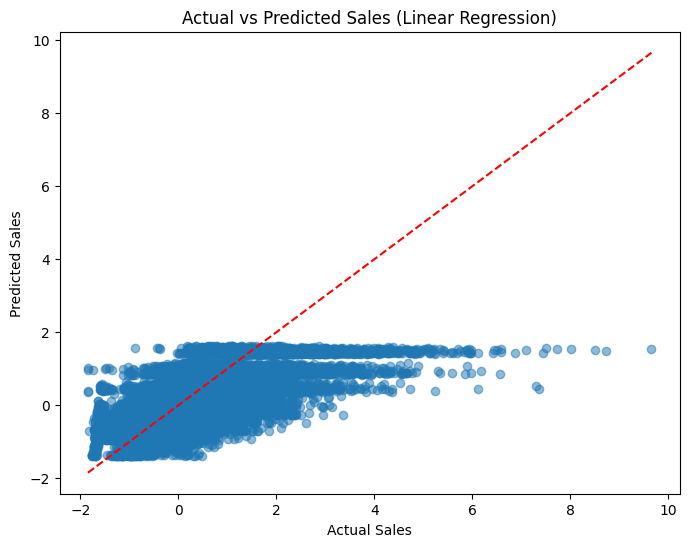

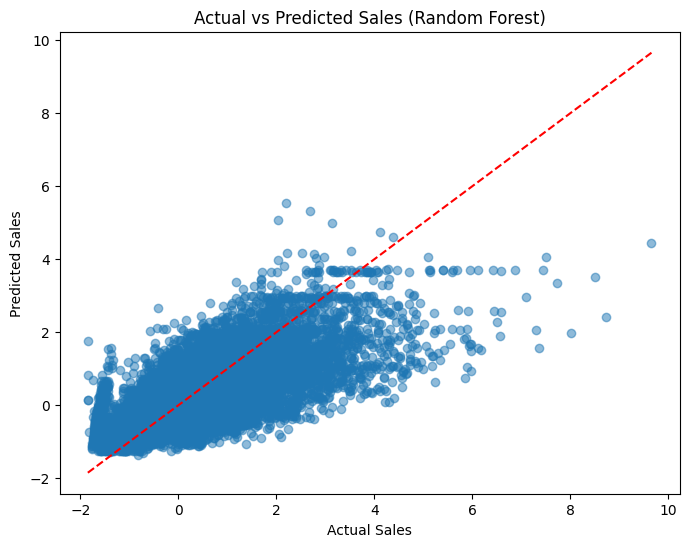

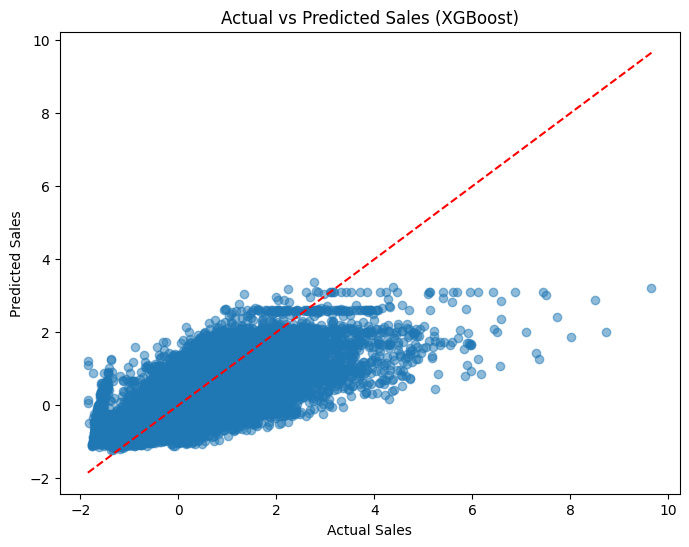

In [49]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(8,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r')  # perfect prediction line
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.title(f'Actual vs Predicted Sales ({model_name})')
    plt.show()

plot_actual_vs_predicted(y_valid, y_pred_lr, "Linear Regression")
plot_actual_vs_predicted(y_valid, y_pred_rf, "Random Forest")
plot_actual_vs_predicted(y_valid, y_pred_xgb, "XGBoost")


RESIDUAL PLOTS

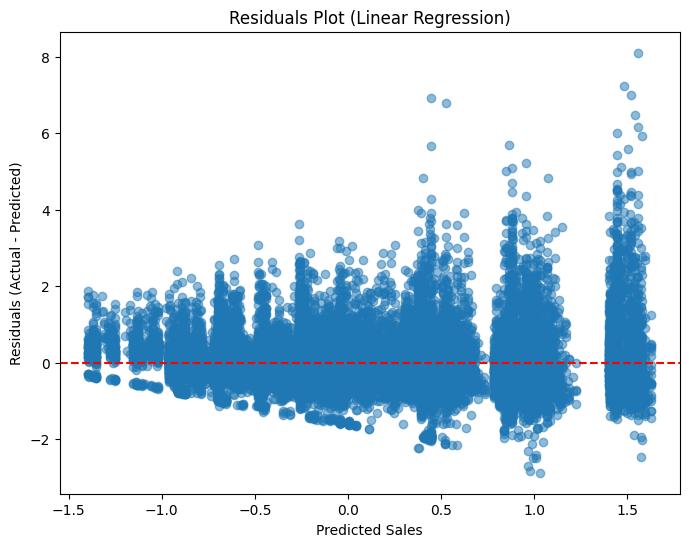

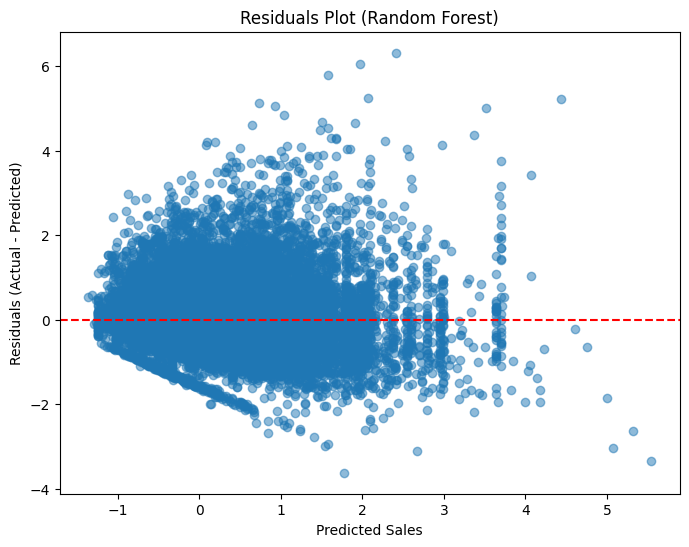

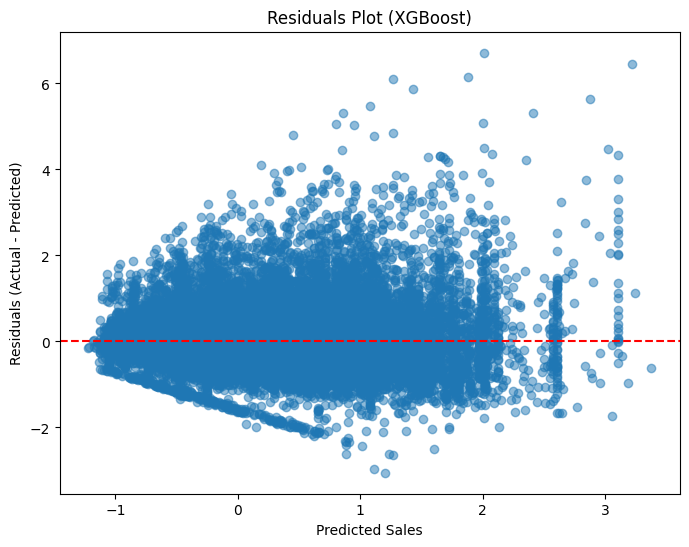

In [50]:
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8,6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Sales')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title(f'Residuals Plot ({model_name})')
    plt.show()

plot_residuals(y_valid, y_pred_lr, "Linear Regression")
plot_residuals(y_valid, y_pred_rf, "Random Forest")
plot_residuals(y_valid, y_pred_xgb, "XGBoost")


# Observations on model training the dataset :

* I chose Linear regression as a base model ; Random Forest as a strong tree-based model ; XGboost as a strong tree-based model uses gradient boosting .

* Linear Regression :
 * RSME : 0.6423
 * MAE : 0.4405
 * R2 Score : 0.5148

* Random Forest :
  * RSME : 0.6739
  * MAE : 0.4635
  * R2 Score : 0.4660

* XGboost:
  * RSME : 0.6188
  * MAE : 0.4233
  * R2 Score : 0.5496

* XGBoost is your best model 
  * Lowest RMSE and MAE
  * Highest R² (goodness of fit)

* Random Forest is worse than Linear Regression — surprising but possible when data is not very nonlinear.
* So I chose XGboost as my final model 


* LSTM and ARIMA are not suitable for this project because:

  * You are working with many stores together.
  * You are using many features, not just Date vs Sales.

* LSTM would require too much time and isn't needed for good performance here.

* ARIMA would require separate modeling for each store and cannot use categorical features like discount, holiday.
